### STEP **THREE** OF DATA PROCESSING PIPELINE

#### This script imports all Conditional CRF's for each subject and the results are visualized 
#### This script performs the 2 exclusion criteria tests: Average Response was withing X STD and Post - Pre CRF ACtivity did not exceed the mean response for Y% of the Time
#### 1: Each response was analyzed per contrast, per harmonic

#### 2 Types of plots (4 in total): 
####  Average CRF before and after excluding  participants fbased on Exclusion Criteria

In [5]:
# load packages
import numpy as np 
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime

### important Params to Set!!!!

In [6]:
NumBins = 6 # number of contrasts
NumHarms = 4 # number of harmonic data: 2F1, 4F1
NumConds = 4

#### Functions

In [7]:
def Concat_Dict_Data(NumSubs,SubNames,d1,d2,iters,s2):
    """
    Combine Single and Double Session Participants data
    Returns: Dict and subject name array

    NumSubs: Number of Participants who completed 2x Sessions 
    d1: Dict Data of Participants who completed 2x Sessions for this condition
    d2: Dict Data of Participants who completed 1 Session for this condition
    iters: **Total Subjects** 
    s2: List of subnames for single sessions  
    """
    s1 = SubNames
    add_onInd = int(iters - NumSubs) # single subjs
    CondSubList = np.hstack((s1,s2)) # Combine subject lists 
    d_sess = np.arange(NumSubs) 
    s_sess = np.arange(add_onInd)
    new_list = np.concatenate((d_sess,s_sess+len(d1)))
    condDict = {}
    for Sub in range(int(iters)): # all data for condition
        ind = int(new_list[Sub]) # restart dict inds
        if Sub < len(d1):
            condDict[Sub]  = d1[ind]
        else: # start saving singles session data 
            condDict[Sub]  = d2[ind - len(d1)]
    return condDict , CondSubList 

def GetGoodSubjInd(noisySubsIdentified, data_sub_list):
    """
    mask participants to exclude with 0 for all files if possible.
    """
    GoodSubList = np.ones((len(data_sub_list)))
    for ns in noisySubsIdentified:
        if ns in data_sub_list:
            badFilePos = np.where(ns== data_sub_list)[0]
            GoodSubList[badFilePos] = 0
            #print(f'Masking pos of participant {data_sub_list[badFilePos]} from df: {coInd}')
        else:
            print(f'Looks like subject {ns} is not in this data set, all good!')
    return GoodSubList

def CleanSubjList(booleanIn,allSubLabs):
    """
    remove bad subjs for anova df. 
    """
    listOut = allSubLabs[booleanIn == 1]
    return listOut

def GetCleanDataPerCo(NumBins,NumHarms, fileIn, gsb):
    '''
    combines data into an array without the bad subjects
    identified previously
    returns: clean_df, 
    '''
    cs = int(np.sum(gsb == 1))
    ns = int(len(fileIn.keys())) # num subs total
    clean_df = np.zeros((cs,NumHarms*NumBins,2))
    for i in range(cs):
        if gsb[i] == 1:
            clean_df[i,:,:] = fileIn[i]
    return clean_df

def GetDiffsPerCo(dfIn):
    """save difference data to get errorbars"""
    [ns,nc,nr] = dfIn.shape
    respDiffData = np.zeros((ns,nc))
    for i in range(ns):
        post = dfIn[i,:,1]
        pre = dfIn[i,:,0]
        respDiffData[i,:] = post-pre
    return respDiffData

def GetCRFErrorBars(prepostdata):
    """
    get average crf per conditon and error bars for average crf 
    """
    ns = prepostdata.shape[0]
    crf_avg = np.mean(prepostdata,axis = 0) # average
    crf_avg_std = np.std(prepostdata,axis = 0) # standrard deviation
    avg_errorbars = crf_avg_std/np.sqrt(ns) # error bars
    return crf_avg,avg_errorbars

def GetDiffErrorBars(respdiffdata):
    """
    get average post-pre diff per conditon and error bars
    """
    ns = respdiffdata.shape[0]
    diff_avg = np.mean(respdiffdata,axis = 0) # average
    diff_avg_std = np.std(respdiffdata,axis = 0) # standrard deviation
    avg_diff_errorbars = diff_avg_std/np.sqrt(ns) # error bars
    return diff_avg,avg_diff_errorbars

In [8]:
# Main Directory of processed file from MatLab
# MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
MainDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\AvgCRFs\\' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Files on hand: {d}')
##############################################
FileN = d[0] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Files on hand: ['AllCondCRF_AllHarmonics_clean2468f_20240401_1445.pkl']
Current WD: C:\plimon\LTP_analysis\RCA_F1\AvgCRFs\AllCondCRF_AllHarmonics_clean2468f_20240401_1445.pkl
Does File #1 Exist? True


In [9]:
loadData = pkl.load(open(file_path1,'rb'))
print(loadData.keys())

dict_keys(['Data', 'SubNames', 'DataSingleSess', 'DSSAttnl', 'DSSAttnR', 'VoiceMemo', 'DictMainKeys', 'ContLevs', 'crfLabs'])


In [10]:
# data for 2 sess subs
data = loadData['Data']
NumSubs = int(len(data[0].keys()))
SubNames = np.array(loadData['SubNames'])
# data for 1 sess subs
data_1s = loadData['DataSingleSess']
attnL_subs = loadData['DSSAttnl']
attnR_subs = loadData['DSSAttnR']

data_labels = loadData['DictMainKeys'] # condition labels for data + data_1s dict keys
contrast_levels = loadData['ContLevs'] # array for contrast labels (indexing)
contrast_labs = loadData['crfLabs'] # list for contrast labels (plotting)

note = loadData['VoiceMemo'] # personal note
print(note)

dl = ['AttnL F1, attended','AttnL F2, ~attended','AttnR F1, ~attended','AttnR F2, attended'] # file names
hl = ['2f','4f','6f','8f'] # harmonic labels 


['This file contains all subjects [single and double] sessions, avg of CRF [12x2] array, original crfs']


In [11]:
cp1 = sns.color_palette("Paired", 12) # color pallete 1 
cp2 = sns.color_palette("hls", 8)  # color pallete 2
sns.set_theme() # set global plot theme
x_lev = np.arange(0,NumBins,1) # x ticks for plotting 

#### Concatenate Double and Single Session Data Based on Respective Session Completed

In [12]:
NumSess = np.zeros((NumConds))
for co in range(NumConds):
    NumSess[co] = int(len(data[co].keys())) + int(len(data_1s[co].keys()))
print(f'Total Subjects for each Condition:{NumSess}')

Total Subjects for each Condition:[34. 34. 32. 32.]


In [13]:
CndDict = {}
SubList = {} 
# combine single and double session data based on what attn condition they completed
CndDict[0], SubList[0] = Concat_Dict_Data(NumSubs,SubNames,d1 = data[0],d2 = data_1s[0],iters = NumSess[0],s2 = attnL_subs)
CndDict[1], SubList[1] = Concat_Dict_Data(NumSubs,SubNames,d1 = data[1],d2 = data_1s[1],iters = NumSess[1],s2 = attnL_subs)
CndDict[2], SubList[2] = Concat_Dict_Data(NumSubs,SubNames,d1 = data[2],d2 = data_1s[2],iters = NumSess[2],s2 = attnR_subs)
CndDict[3], SubList[3] = Concat_Dict_Data(NumSubs,SubNames,d1 = data[3],d2 = data_1s[3],iters = NumSess[3],s2 = attnR_subs)

#### Remove Participants Based On Visual Inspection Here

In [14]:
coIn = 0
conLab = data_labels[coIn]
x = CndDict[coIn]
x_lab = SubList[coIn]
xKeys = int(len(x.keys()))
# remove hashtag to plot / exlude ppl
# for p in range(xKeys):
#     dIn = x[p]
#     fig, axs  = plt.subplots(1,4,figsize = (12,3), sharey = False)
#     for i in range(4):
#         s = i*NumBins
#         e = s + (NumBins)
#         axs[i].plot(dIn[s:e,0], linewidth = 1, color = 'black', label = f'{hl[i]} pre')
#         axs[i].plot(dIn[s:e,1], linewidth = 2, color = cp2[i], label = f'{hl[i]} post')
#         axs[i].plot((dIn[s:e,1] - dIn[s:e,0]),color = cp1[i+1], label = f'{hl[i]} post-pre')
#         axs[i].hlines(0, xmin = 0, xmax = 5, color = 'black')
#         #axs[c].set_xticks(range(len(contrast_levels_labs)))
#         #axs[c].set_xticklabels(contrast_levels_labs)
#         axs[0].set_title(f'{x_lab[p]}, {conLab}')
#         axs[i].legend(fontsize = 9)
#     plt.show()

In [15]:
#noisySubsIdentified = []
noisySubsIdentified = ['2671','2661','2677','2678']

GoodSubj_bool = {}
for coInd in range(NumConds):
    GoodSubj_bool[coInd] = GetGoodSubjInd(noisySubsIdentified, data_sub_list = SubList[coInd])
    

Looks like subject 2678 is not in this data set, all good!
Looks like subject 2678 is not in this data set, all good!


In [16]:
SubjlistOut = {}
for co in range(NumConds):
    SubjlistOut[co]=CleanSubjList(booleanIn = GoodSubj_bool[co],allSubLabs = SubList[co])


In [17]:
cleanData = {} # include in pkl file
for co in range(NumConds):
    cleanData[co] = GetCleanDataPerCo(NumBins,NumHarms, fileIn = CndDict[co], gsb = GoodSubj_bool[co])
    #print(cleanData[co].shape)

cleanDiffData = {} # include in pkl file
for co in range(NumConds):
    cleanDiffData[co] = GetDiffsPerCo(dfIn = cleanData[co])
    #print(cleanDiffData[co].shape)
    
co_crf = {}
co_crf_eb = {}
co_respdiff = {}
co_respdiff_eb = {}

for co in range(NumConds):
    co_crf[co],co_crf_eb[co] = GetCRFErrorBars(prepostdata = cleanData[co])
    co_respdiff[co],co_respdiff_eb[co] = GetDiffErrorBars(respdiffdata = cleanDiffData[co])



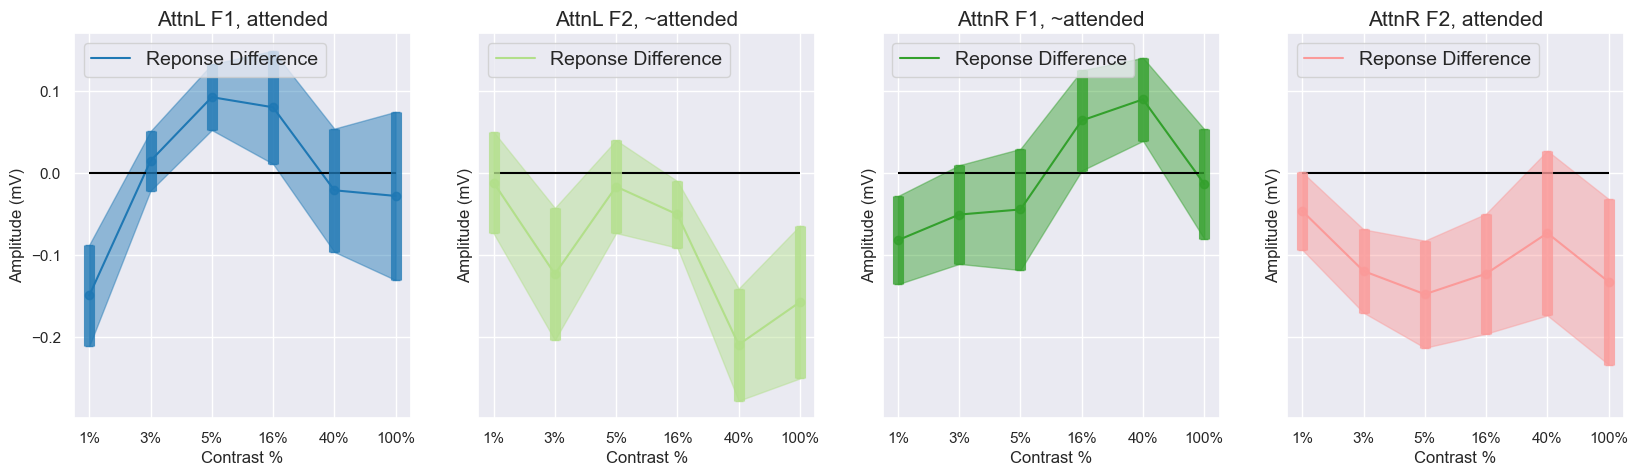

In [18]:
fig,axs = plt.subplots(1,4, figsize=(20,5),sharey = True)

Harmon = 1

for i in range(4):
    axs[i].plot(co_respdiff[i][0+(NumBins*Harmon):6+(NumBins*Harmon)],label = f'Reponse Difference',color = cp1[i+1])
    axs[i].hlines(0, xmin = 0, xmax = 5, color = 'black')
    axs[i].errorbar(np.arange(NumBins),co_respdiff[i][0+(NumBins*Harmon):6+(NumBins*Harmon)],co_respdiff_eb[i][0+(NumBins*Harmon):6+(NumBins*Harmon)],fmt = 'o',color = cp1[i+1], linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.8)
    axs[i].fill_between(np.arange(NumBins), co_respdiff[i][0+(NumBins*Harmon):6+(NumBins*Harmon)] - co_respdiff_eb[i][0+(NumBins*Harmon):6+(NumBins*Harmon)], co_respdiff[i][0+(NumBins*Harmon):6+(NumBins*Harmon)] + co_respdiff_eb[i][0+(NumBins*Harmon):6+(NumBins*Harmon)], color = cp1[i+1], alpha=0.45)

    axs[i].set_title(dl[i], fontsize = 15)
    axs[i].set_ylabel('Amplitude (mV)')
    axs[i].set_xlabel('Contrast %')
    axs[i].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
    axs[i].legend(fontsize = 14, loc = 'upper left')

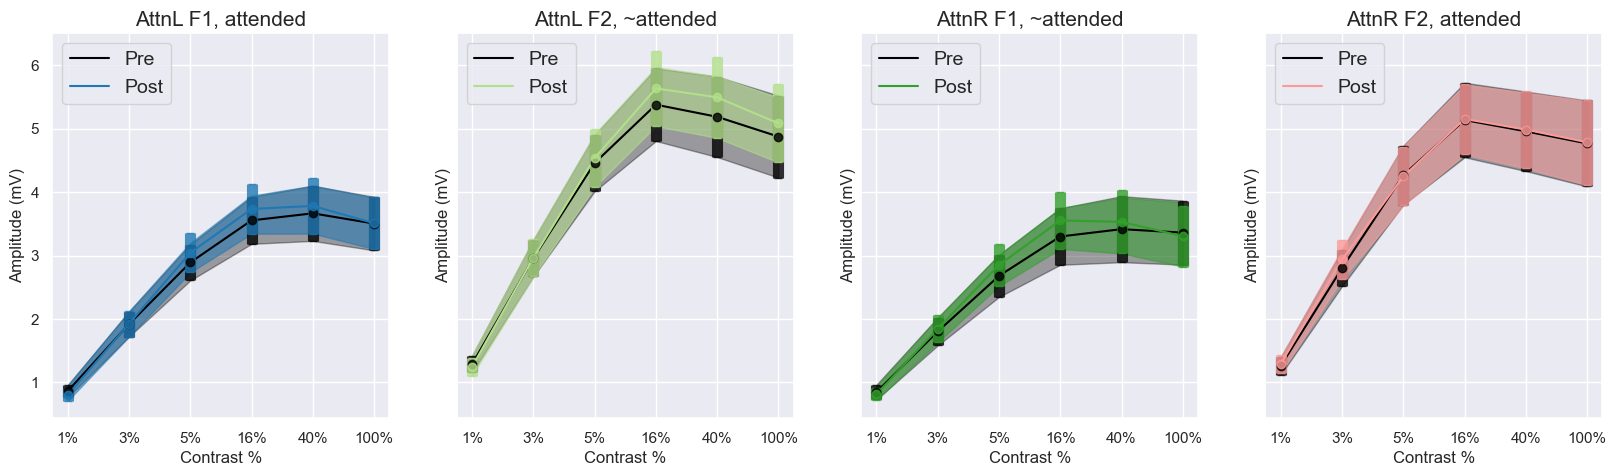

In [19]:
fig,axs = plt.subplots(1,4, figsize=(20,5),sharey = True)

Harmon = 0

for i in range(4):
    axs[i].plot(co_crf[i][0+(NumBins*Harmon):6+(NumBins*Harmon),0], label = f'Pre',color = 'black')
    axs[i].errorbar(np.arange(NumBins),co_crf[i][0+(NumBins*Harmon):6+(NumBins*Harmon),0],co_crf_eb[i][0+(NumBins*Harmon):6+(NumBins*Harmon),0],fmt = 'o',color = 'black', linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.8)
    axs[i].fill_between(np.arange(NumBins), co_crf[i][0+(NumBins*Harmon):6+(NumBins*Harmon),0] - co_crf_eb[i][0+(NumBins*Harmon):6+(NumBins*Harmon),0], co_crf[i][0+(NumBins*Harmon):6+(NumBins*Harmon),0] + co_crf_eb[i][0+(NumBins*Harmon):6+(NumBins*Harmon),0], color = 'black', alpha=0.35)

    axs[i].plot(co_crf[i][0+(NumBins*Harmon):6+(NumBins*Harmon),1],label = f'Post',color = cp1[i+1])
    axs[i].errorbar(np.arange(NumBins),co_crf[i][0+(NumBins*Harmon):6+(NumBins*Harmon),1],co_crf_eb[i][0+(NumBins*Harmon):6+(NumBins*Harmon),1],fmt = 'o',color = cp1[i+1], linewidth = 3, elinewidth = 8, capsize = 3, alpha = 0.8)
    axs[i].fill_between(np.arange(NumBins), co_crf[i][0+(NumBins*Harmon):6+(NumBins*Harmon),1] - co_crf_eb[i][0+(NumBins*Harmon):6+(NumBins*Harmon),1], co_crf[i][0+(NumBins*Harmon):6+(NumBins*Harmon),0] + co_crf_eb[i][0+(NumBins*Harmon):6+(NumBins*Harmon),1], color = cp1[i+1], alpha=0.55)

    axs[i].set_title(dl[i], fontsize = 15)
    axs[i].set_ylabel('Amplitude (mV)')
    axs[i].set_xlabel('Contrast %')
    axs[i].set_xticks(ticks = np.arange(NumBins),labels = contrast_labs)
    axs[i].legend(fontsize = 14, loc = 'upper left')

In [24]:
note = ['This data contains clean,processed (post-pre) contrast response function differences for each condition']

In [25]:
DictOut = {}

DictOut['SubjNames'] = SubjlistOut
DictOut['DiffData'] = cleanDiffData # response differences - 1 row = 1 subj
DictOut['PPData'] = cleanData # pre post CRF
#DictOut['coSubNames'] = coSubList # subject names -  need to figure out next for anova df

# pre post average data
DictOut['Avg'] = co_crf # average of data differences 
DictOut['ErrorBars'] = co_crf_eb # error bars 
# post - pre induction response data averaged
DictOut['DiffAvg'] = co_respdiff # average of data differences 
DictOut['DiffErrorBars'] = co_respdiff_eb # error bars

DictOut['VoiceMemo'] = note # personal note f what data contains 
DictOut['DictMainKeys'] = data_labels # condition labels per key
DictOut['ContLevs'] = contrast_levels # contrasts used for sweep
DictOut['crfLabs'] = contrast_labs # string of avob for plotting


In [26]:
# set save data dir 
# Set directory to save NR Data in ..new folder
# SaveDataDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir where files (.pkl, .csv) will be saved
SaveDataDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\CleanCRFDiff\\' # set dir where files (.pkl, .csv) will be saved
FileOutName = '2468F_clean' # make sure this file changes each time you save
######################################################
dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M") # set the above as a string ...
FileN = f'{FileOutName}_{fdnt}.pkl' 
MatLabFileN = f'{FileOutName}_{fdnt}.mat'

NewFileNPath = os.path.join(SaveDataDir,FileN)

print('Full New File Dir: ', NewFileNPath)

if not os.path.exists(SaveDataDir):
    os.makedirs(SaveDataDir)
print('Path to Save File is:',SaveDataDir)

Full New File Dir:  C:\plimon\LTP_analysis\RCA_F1\CleanCRFDiff\2468F_clean_20240403_2247.pkl
Path to Save File is: C:\plimon\LTP_analysis\RCA_F1\CleanCRFDiff\


In [27]:
saveFile = 'y'

if saveFile == 'y':
 
 with open(NewFileNPath, 'wb') as file:
    pkl.dump(DictOut, file, protocol=pkl.HIGHEST_PROTOCOL)
    # save as .mat file or .csv file to import into matlab 
    
    print('Average CRF Differences Saved! :))')
else:
    print('Did Not Save File! Change file name before switching to y!')

Average CRF Differences Saved! :))
